In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np


DATA_PATH = "/home/airplaneless/source/mri/datasets/LV10slices.npy"


import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, ker_size, pd):
        super(ConvBlock, self).__init__()
        self.pad1 = nn.ReflectionPad2d(int(ker_size/2))
        self.conv1 = nn.Conv2d(in_channels, out_channels, ker_size)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        
        self.pad2 = nn.ReflectionPad2d(int(ker_size/2))
        self.conv2 = nn.Conv2d(out_channels, out_channels, ker_size)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p=pd)
        
    def forward(self, x):
        x = self.conv1(self.pad1(x))
        x = self.bnorm1(x)
        x = F.relu(x)
        x = self.conv2(self.pad2(x))
        x = self.bnorm2(x)
        up = F.relu(x)
        down = self.pool(up)
        down = self.dropout(down)
        return up, down
    
class UpConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, ker_size, pd):
        super(UpConvBlock, self).__init__()
        self.pad1 = nn.ReflectionPad2d(int(ker_size/2))
        self.conv1 = nn.Conv2d(in_channels, out_channels, ker_size)
        self.pad2 = nn.ReflectionPad2d(int(ker_size/2))
        self.conv2 = nn.Conv2d(out_channels, out_channels, ker_size)
        self.dropout = nn.Dropout2d(p=pd)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.conv1(self.pad1(x))
        x = F.relu(x)
        x = self.conv2(self.pad2(x))
        x = F.relu(x)
        return x
        
    
class Unet(nn.Module):
    
    # 256x256
    
    def __init__(self, nfilters, kersize):
        super(Unet, self).__init__()
        self.nf = nfilters
        self.ks = kersize
        # 1x256x256 -> Nx128x128
        self.cblock1 = ConvBlock(1, self.nf, self.ks, 0.2)
        # Nx128x128 -> 2Nx64x64
        self.cblock2 = ConvBlock(self.nf, self.nf*2, self.ks, 0.5)
        # 2Nx64x64 -> 4Nx32x32
        self.cblock3 = ConvBlock(self.nf*2, self.nf*4, self.ks, 0.5)
        # 4Nx32x32 -> 8Nx16x16
        self.cblock4 = ConvBlock(self.nf*4, self.nf*8, self.ks, 0.5)
        # middle
        self.pad1 = nn.ReflectionPad2d(int(self.ks/2))
        self.conv1 = nn.Conv2d(self.nf*8, self.nf*8, self.ks)
        self.pad2 = nn.ReflectionPad2d(int(self.ks/2))
        self.conv2 = nn.Conv2d(self.nf*8, self.nf*8, self.ks)
        # 8Nx16x16 -> 4Nx32x32
        self.upconv1 = nn.ConvTranspose2d(self.nf*8, self.nf*8, 2, 2)
        self.upblock1 = UpConvBlock(self.nf*8*2, self.nf*4, self.ks, 0.5)
        # 4Nx32x32 -> 2Nx64x64
        self.upconv2 = nn.ConvTranspose2d(self.nf*4, self.nf*4, 2, 2)
        self.upblock2 = UpConvBlock(self.nf*4*2, self.nf*2, self.ks, 0.5)
        # 2Nx64x64 -> Nx128x128
        self.upconv3 = nn.ConvTranspose2d(self.nf*2, self.nf*2, 2, 2)
        self.upblock3 = UpConvBlock(self.nf*2*2, self.nf, self.ks, 0.5)
        # Nx128x128 -> 1x256x256
        self.upconv4 = nn.ConvTranspose2d(self.nf, self.nf, 2, 2)
        self.upblock4 = UpConvBlock(self.nf*2, self.nf, self.ks, 0.5)
        self.pad3 = nn.ReflectionPad2d(int(self.ks/2))
        self.conv1x1 = nn.Conv2d(self.nf, 1, self.ks)
        
    def forward(self, x):
        x1, down = self.cblock1(x)
        x2, down = self.cblock2(down)
        x3, down = self.cblock3(down)
        x4, down = self.cblock4(down)
        
        xm = self.conv1(self.pad1(down))
        xm = F.relu(xm)
        xm = self.conv2(self.pad2(xm))
        xm = F.relu(xm)
        
        ux = self.upconv1(xm)
        ux = torch.cat([ux, x4], 1)
        ux = self.upblock1(ux)
        
        ux = self.upconv2(ux)
        ux = torch.cat([ux, x3], 1)
        ux = self.upblock2(ux)
        
        ux = self.upconv3(ux)
        ux = torch.cat([ux, x2], 1)
        ux = self.upblock3(ux)
        
        ux = self.upconv4(ux)
        ux = torch.cat([ux, x1], 1)
        ux = self.upblock4(ux)
        
        ux = self.conv1x1(self.pad3(ux))
                    
        return torch.sigmoid(ux)
    
class ACDCdataset(torch.utils.data.Dataset):
    
    def __init__(self, transform=None):
        x, y = np.load(DATA_PATH)
        nsamples = x.shape[0]
        img_size = x.shape[1]
        x = x[:, :, :, :].swapaxes(3,1).reshape((nsamples*10, img_size, img_size))
        y = y[:, :, :, :].swapaxes(3,1).reshape((nsamples*10, img_size, img_size))
        x = self.getReshapedImages(x)
        y = self.getReshapedImages(y)
        self.images = x
        self.masks = y
        self.transform = transform
        
    @staticmethod
    def getReshapedImages(arr):
        dim = arr.shape
        return arr.reshape((dim[0], dim[1], dim[2], 1))
        
    def __len__(self):
        return len(self.masks)
    
    def __getitem__(self, i):
        img = self.images[i]
        mask = self.masks[i]
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return (img, mask)


def dice_loss(inputs, target):
    
    iflat = inputs.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1-((2. * intersection) / (iflat.sum() + tflat.sum()))

def imshow(images, masks, predictions=None):
    import pylab as plt
    from matplotlib import cm
    for i in range(masks.shape[0]):
        img = images[i]
        mask = masks[i]
        if predictions is not None:
            prediction = predictions[i]
        fig, ax = plt.subplots(ncols=2)
#         ax[0].imshow(img.numpy()[0,:,:], cmap=cm.hot)
        ax[0].imshow(mask.numpy()[0,:,:], alpha=0.3)
        if predictions is not None:
#             ax[1].imshow(img.numpy()[0,:,:], cmap=cm.hot)
            ax[1].imshow(prediction.numpy()[0,:,:], alpha=0.3)
        plt.show()

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = ACDCdataset(transform=transform)

datagenerator = torch.utils.data.DataLoader(dataset=dataset, batch_size=8, shuffle=True)

In [7]:
import torch.optim as optim

net = Unet(32, 3)
optimizer = optim.Adam(net.parameters())
criterion = dice_loss

In [4]:
from tqdm import tqdm

EPOCHS = 20

epochs = range(EPOCHS)
losses = np.zeros(EPOCHS)

net.train()

for epoch in epochs:
    batches = tqdm(datagenerator)
    for batch in batches:
        imgs, masks = batch
        
        optimizer.zero_grad()
        outputs = net(imgs.float())
        loss = criterion(outputs.float(), masks.float())
        loss.backward()
        optimizer.step()
        
        losses[epoch] += loss.item()
        
        batches.set_description("loss: {}".format(round(loss.item(), 4)))
        
    print("\nloss: {}\n".format(round(losses[epoch] / len(batches), 3)))

loss: 0.8412:  83%|████████▎ | 65/78 [10:04<04:57, 22.86s/it]

KeyboardInterrupt: 

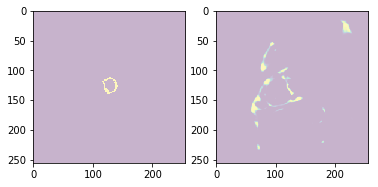

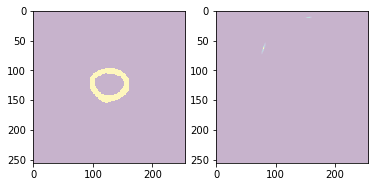

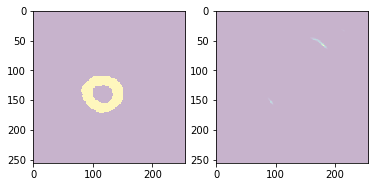

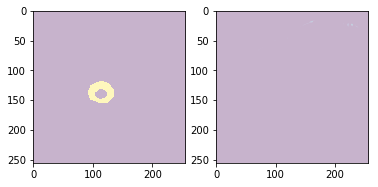

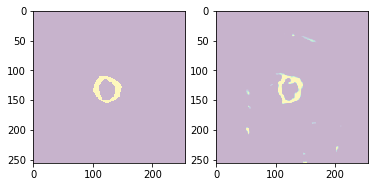

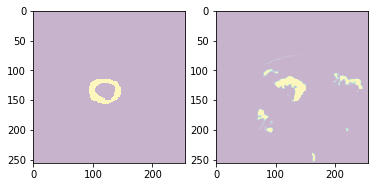

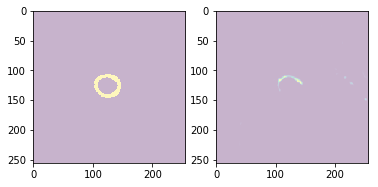

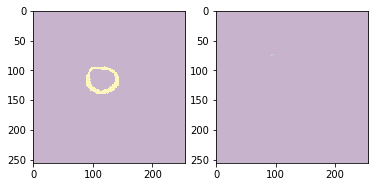

In [6]:
it = iter(datagenerator)
images, masks = next(it)
predictions = net(images.float())
imshow(images, masks, predictions.detach())